In [1]:
# !pip install vrplib

In [3]:
import random
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import vrplib
from types import SimpleNamespace
import copy
from collections import deque

In [4]:
%matplotlib inline

# Genetic Algorithm summary

### Data

In [9]:
vrp_data = vrplib.read_instance("data/ORTEC-n405-k18.vrp.txt")
bks = SimpleNamespace(**vrplib.read_solution("data/ORTEC-n405-k18.sol.txt"))

### Plot solution

In [12]:
def plot_solution(solution, name="Best known solution"):
    try:
        r = solution.routes
        cost = solution.cost
    except AttributeError:
        r = solution
        cost = solution_cost(r)
    
    fig, ax = plt.subplots(figsize=(12, 10))
    cmap = plt.cm.rainbow(np.linspace(0, 1, len(r)))
    
    for idx, route in enumerate(r):
        ax.plot(
            [vrp_data["node_coord"][loc][0] for loc in [0] + route + [0]],
            [vrp_data["node_coord"][loc][1] for loc in [0] + route + [0]],
            color=cmap[idx],
            marker=".",
        )

    # Plot the depot
    kwargs = dict(label="Depot", zorder=3, marker="*", s=750)
    ax.scatter(*vrp_data["node_coord"][0], c="tab:red", **kwargs)

    ax.set_title(f"{name}\n Total distance: {cost}")
    ax.set_xlabel("X-coordinate")
    ax.set_ylabel("Y-coordinate")
    ax.legend(frameon=False, ncol=3)

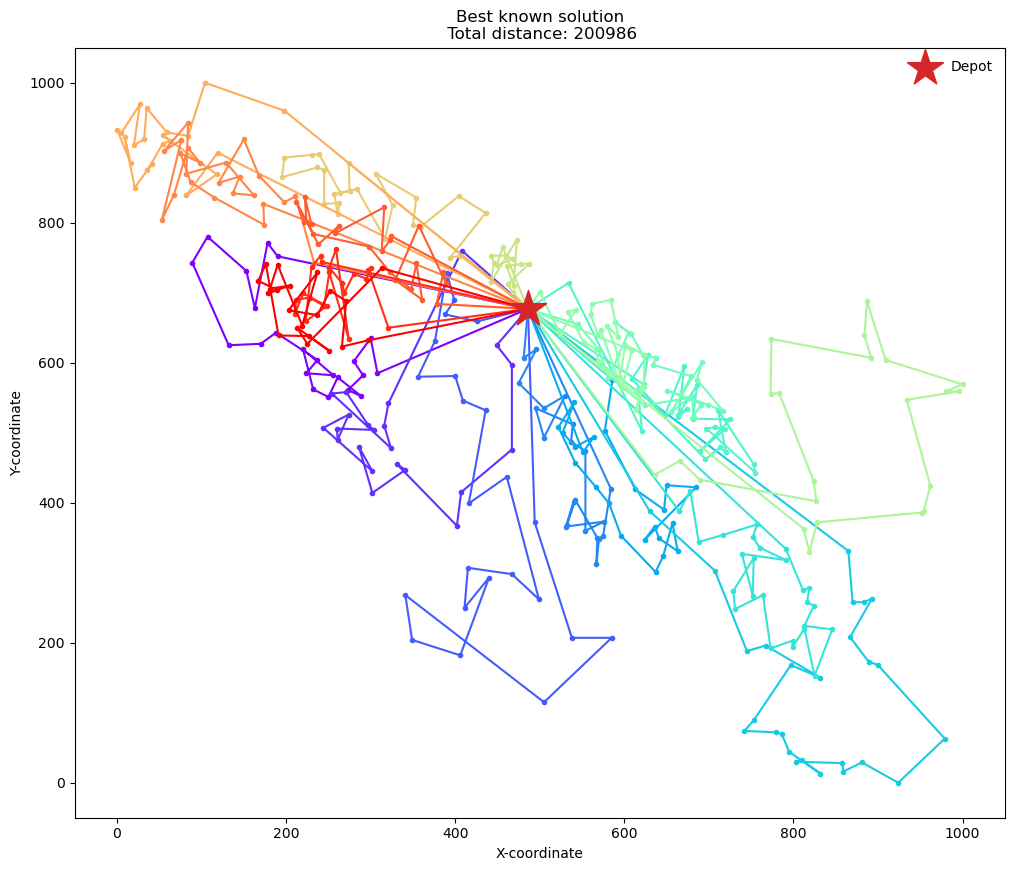

In [14]:
plot_solution(bks)

In [16]:
bks.cost

200986

In [37]:
def route_cost(tour, distances):
    full_route = [0] + tour + [0] # Add dc as starting and ending point

    return sum(
        distances[full_route[idx]][full_route[idx + 1]] for idx in range(len(full_route) - 1)
    )

class SolutionPermitation:
    
    def __init__(self, customers, dist_matrix, demand, max_capacity, penalty):
        self.customers = customers
        self.routes = self._route_creation(demand, max_capacity)
        self.cost = self._cost(dist_matrix)
        self.fitness = self._fitness(penalty)
        
    def _cost(self, dist_matrix):
        """
        """
        cost = 0
        for route in self.routes:
            cost += route_cost(route, dist_matrix)
        return cost


    def _fitness(self, penalty):
        """
        """
        return self.cost + penalty * len(self.routes)
            

    def _route_creation(self, demand, max_capacity):
        """
        """
        routes = [[]]
        current_route_demand = 0
        for cust in self.customers:
            if current_route_demand + demand[cust] < max_capacity:
                routes[-1].append(cust)
                current_route_demand += demand[cust]
            else:
                routes.append([cust])
                current_route_demand = demand[cust]
                

        return routes

    def __gt__(self, cls):
        return self.fitness > cls.fitness

    def __repr__(self):
        return f"Solution cost: {self.cost}, fitness: {self.fitness}"

    def __iter__(self):
        return self
    
    

In [157]:
class GAVrp:
    
    def __init__(self, customers: int, 
                 population_size: int, 
                 demand, 
                 distance_matrix, 
                 customer_coords, 
                 vehicle_max_capacity,
                 generations=600, 
                 penalty=0.9, 
                 crossover_rate=0.8,
                 mutation_rate=0.5, 
                 remove_rate=0.4
                ):
        self.customers = list(range(1,customers))
        self.population_size = population_size
        self.demand = demand
        self.dist_matrix = distance_matrix
        self.customer_coords = customer_coords
        self.vehicle_max_capacity = vehicle_max_capacity
        self.penalty = penalty
        self.generations = generations
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.remove_rate = remove_rate
        self.bks = None
        self.history = []
        
        self.population = self._init_population()

    def _init_population(self):
        """
        """
        populations = []
        for _ in range(self.population_size):
            perm = self.customers[:]
            random.shuffle(perm)
            populations.append(SolutionPermitation(perm, self.dist_matrix, self.demand, self.vehicle_max_capacity, self.penalty))

        return populations

    def _tournament_selection(self):
        """
        """
        candidate_solutions = np.random.choice(self.population, size=20)
        best_candidate = min(candidate_solutions, key=lambda c: c.fitness)
        self.population.remove(best_candidate)
        return best_candidate

    def _ox(self, p_one, p_two, i, j):
        """
        """
        child = [None] * len(p_one.customers)
        for el in range(i, j+1):
            child[el] = p_one.customers[el]
        fill = deque([x for x in p_two.customers if x not in child])
        for el in range(len(p_one.customers)):
            if child[el] is None:
                child[el] = fill.popleft()
                
        return SolutionPermitation(child, self.dist_matrix, self.demand, self.vehicle_max_capacity, self.penalty)

    def _crossover(self, parent_one, parent_two):
        """
        """
        if random.random() < self.crossover_rate:
            start_idx, end_idx = sorted(random.sample(range(len(self.customers)), 2))
            
            child_one = self._ox(parent_one, parent_two, start_idx, end_idx )
            child_two = self._ox(parent_two, parent_one, start_idx, end_idx )
            
            return child_one, child_two
        return parent_one, parent_two

    def _mutation(self, child):
        """
        """
        if random.random() < self.mutation_rate:
            i, j = sorted(random.sample(range(self.population_size), 2))
            child.customers[i], child.customers[j] = child.customers[j], child.customers[i]

        if random.random() < 0.01:
            child = self._random_greedy_mutation(child)
        return child

    def _random_greedy_mutation(self, child):
        """
        """
        number_of_mutaions = 200
        idx = random.sample(range(len(self.customers)), 1)[0]
        unvisited = child.customers[idx:idx+number_of_mutaions]
        sub_route = [0]
        while unvisited:
            # Add the nearest unvisited customer to the route till max capacity
            current = sub_route[-1]
            nearest = [nb for nb in self.neighbours_sorted_by_distance(current) if nb in unvisited][0]

            sub_route.append(nearest)
            unvisited.remove(nearest)

        customers = sub_route[1:]
        new_cust = []
        for i in range(len(self.customers)):
            if i < idx or i >= idx + number_of_mutaions:
                new_cust.append(child.customers[i])
            else:
                new_cust.append(customers.pop())

        return SolutionPermitation(new_cust, self.dist_matrix, self.demand, self.vehicle_max_capacity, self.penalty)

    def neighbours_sorted_by_distance(self, cust):
        """
        """
        return np.argsort(self.dist_matrix[cust])[1:]

    def _remove_worse(self):
        """
        """
        self.population.sort(key=lambda s: s.fitness)
        idx = int(len(self.population) * (1 - self.remove_rate))
        self.population = self.population[:idx]
        random.shuffle(self.population)
        
    
    def solve(self):
        
        for _ in range(self.generations):

            self._remove_worse()
            while len(self.population) < self.population_size:
                p_one = self._tournament_selection()
                p_two = self._tournament_selection()
                
                child_one, child_two = self._crossover(p_one, p_two)
    
                child_one = self._mutation(child_one)
                child_two = self._mutation(child_two)
                
                self.population.append(child_one)
                self.population.append(child_two)
                self.population.append(p_one)
                self.population.append(p_two)
    
                current_best = min(child_one, child_two)
                self.history.append(current_best.cost)
                if self.bks is None or current_best < self.bks:
                    self.bks = copy.deepcopy(current_best)
                    print(f"Current best {self.bks}")
        

In [159]:
s = GAVrp(
    customers=vrp_data['dimension'],
    population_size=100,
    demand=vrp_data['demand'],
    distance_matrix=vrp_data['edge_weight'],
    customer_coords=vrp_data['node_coord'],
    vehicle_max_capacity=vrp_data['capacity']
)

In [161]:
s.solve()

Current best Solution cost: 1133673.0, fitness: 1133689.2
Current best Solution cost: 1126159.0, fitness: 1126175.2
Current best Solution cost: 1118669.0, fitness: 1118685.2
Current best Solution cost: 1115213.0, fitness: 1115229.2
Current best Solution cost: 1110861.0, fitness: 1110877.2
Current best Solution cost: 1108413.0, fitness: 1108429.2
Current best Solution cost: 1107661.0, fitness: 1107677.2
Current best Solution cost: 1107038.0, fitness: 1107054.2
Current best Solution cost: 1106638.0, fitness: 1106654.2
Current best Solution cost: 1104284.0, fitness: 1104300.2
Current best Solution cost: 1103919.0, fitness: 1103935.2
Current best Solution cost: 687961.0, fitness: 687977.2
Current best Solution cost: 687784.0, fitness: 687800.2
Current best Solution cost: 687170.0, fitness: 687186.2
Current best Solution cost: 434075.0, fitness: 434091.2
Current best Solution cost: 430370.0, fitness: 430386.2
Current best Solution cost: 427771.0, fitness: 427787.2
Current best Solution cost

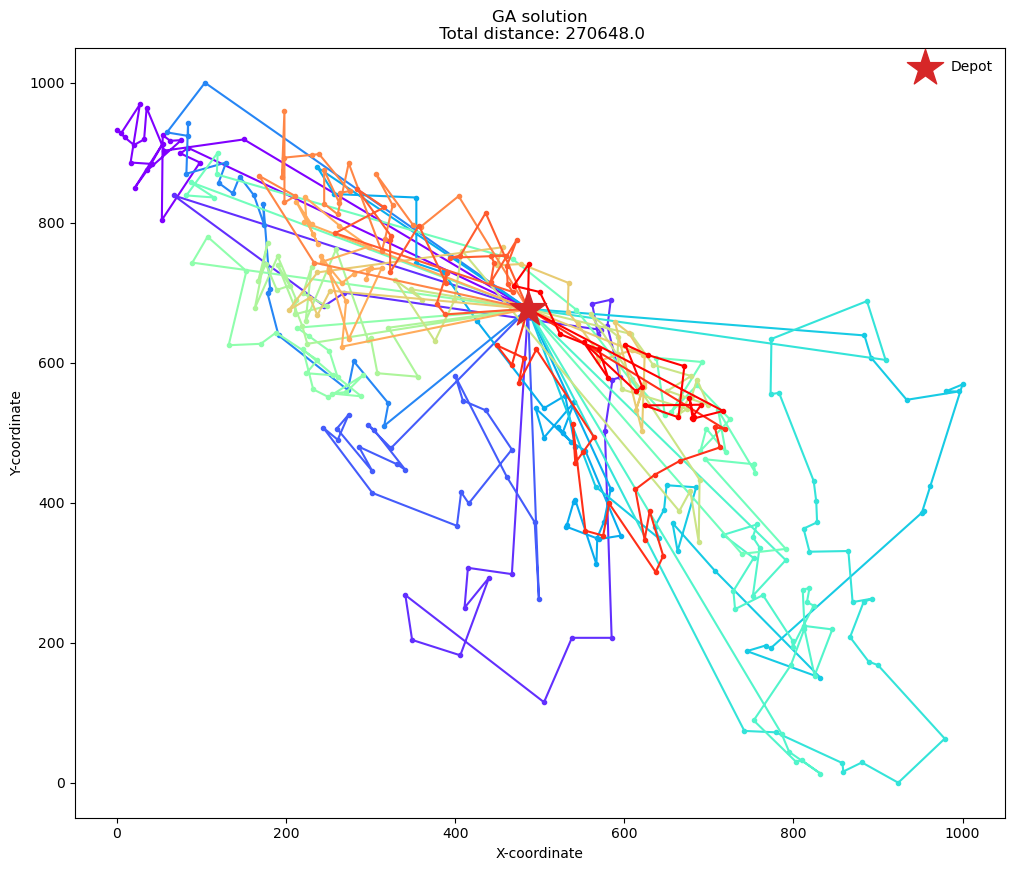

In [162]:
plot_solution(s.bks, "GA solution")

In [163]:
def plot_objective(series):
    fig, ax = plt.subplots(figsize=(12, 10))

    ax.plot(series)    
    

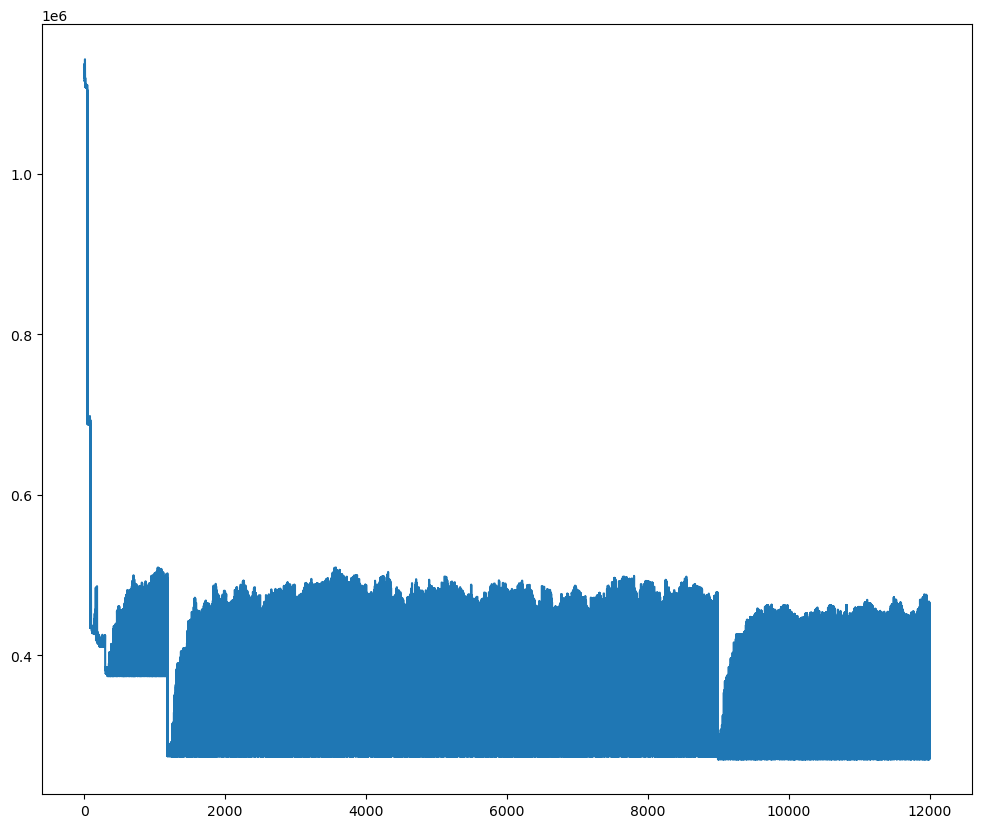

In [164]:
plot_objective([x for x in s.history])